# Análisis exploratorio de datos (EDA)

In [1]:
# %pip install pandas
import pandas as pd

## Importamos el dataset

In [29]:
USER = "antoniotrapote"
REPO = "chord-prediction-tfm"
BRANCH = "main"
PATH_IN_REPO = "anexos/data/songdb.csv"
URL = f"https://raw.githubusercontent.com/{USER}/{REPO}/{BRANCH}/{PATH_IN_REPO}"

raw_df = pd.read_csv(URL)
print(raw_df.info())
raw_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2613 entries, 0 to 2612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       2613 non-null   object
 1   composedby  2613 non-null   object
 2   key         2613 non-null   object
 3   timesig     2613 non-null   object
 4   bars        2613 non-null   int64 
 5   chordprog   2613 non-null   object
dtypes: int64(1), object(5)
memory usage: 122.6+ KB
None


,title,composedby,key,timesig,bars,chordprog
0,Lullaby of Birdland,George Shearing,Ab,4 4,32,Fm7 Dm7b5 | G7b9 C7b9 | Fm7 DbM7 | Bbm7 Eb7 |\...
1,It's A Most Unusual Day,Jimmy McHugh and HYarold Adamson,G,3 4,72,F#/G F#/G G | Em7 | Am7 | D7 |\nF#/G F#/G G | ...
2,Jump Monk,Charles Mingus,Ab,4 4,54,Fm7 DbM7 | G7b5 C7 | Fm7 DbM7 | G7b5 C7 |\nFm7...
3,Nuages,Django Reinhardt and Jacques Larme,G,4 4,32,Bbm7 Eb7 | Am7b5 D7b9 | G6 Am7 | Bm7 |\nBbm7 E...
4,Love Me Do,John Lennon and Paul McCartney,G,4 4,48,G | C | G | C |\nG | C | C | C |\nC | G | C | ...


## Key

Observamos que **únicamente hay etiquetadas tonalidades mayores**. Esto indica que las canciones entonalidades menores aparecerán etiquetadas como su relativo mayor. Debemos prestar especial atención a esto, ya que puede afectar a la predicción de acordes.

Ejemplo: 'Autumn Leaves', etiquetada como key='Bb', en realidad debería ser key='Gm' 

In [30]:
raw_df['key'].value_counts()

key
C     857
F     488
Eb    401
Bb    349
G     214
Ab    144
Db     65
D      47
A      19
Gb     14
E      13
B       2
Name: count, dtype: int64

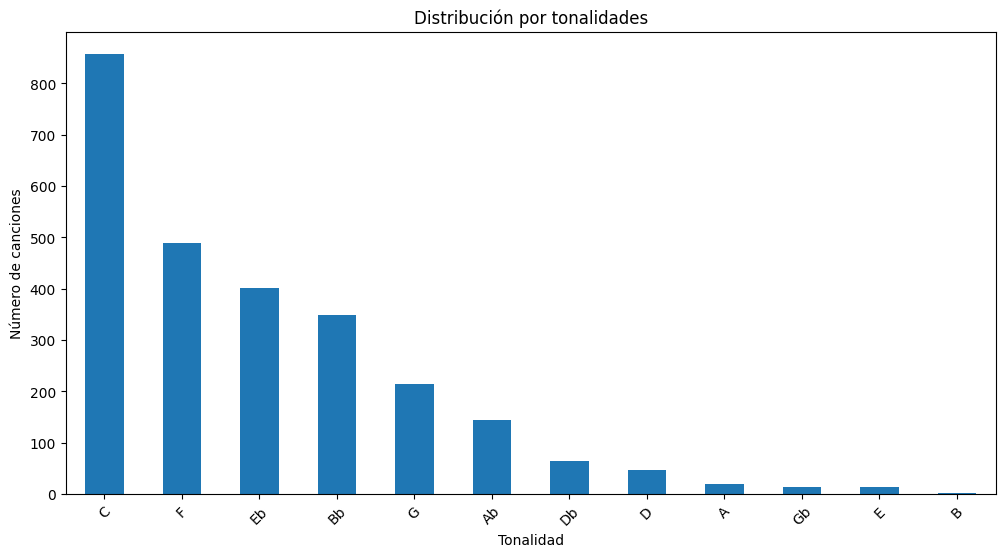

In [6]:
# %pip install matplotlib
# Gráfico de barras con el número de canciones por tonalidad
import matplotlib.pyplot as plt

# Contar el número de canciones por tonalidad
tonalidades = raw_df['key'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
tonalidades.plot(kind='bar')
plt.title('Distribución por tonalidades')
plt.xlabel('Tonalidad')
plt.ylabel('Número de canciones')
plt.xticks(rotation=45)
plt.show()

In [7]:
raw_df[raw_df['title']=="Autumn Leaves"]

,title,composedby,key,timesig,bars,chordprog
2471,Autumn Leaves,Joseph Kosma,Bb,4 4,32,Cm7 | F7 | BbM7 | EbM7 |\nAm7b5 | D7 | Gm7 | G...


## Timesig

Observamos que **el 91,58% de las canciones de nuestro dataset están en 4/4**. 

Si utilizásemos únicamente los registros con 'timesig' == '4/4', obtendríamos un conjunto de datos mucho más manejable en tanto a representar la información temporal de los acordes (posición y duración).

In [8]:
raw_df['timesig'].value_counts(normalize=True)

timesig
4 4     0.915806
3 4     0.069269
6 8     0.004210
2 4     0.002296
6 4     0.001914
5 4     0.001914
2 2     0.001531
12 8    0.001148
7 4     0.000765
3 2     0.000383
10 4    0.000383
11 4    0.000383
Name: proportion, dtype: float64

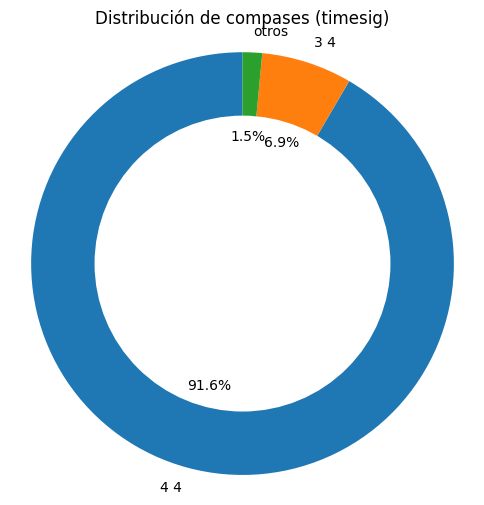


Categorías agrupadas en 'Otros' (< 5.0%):
  6 8: 0.004 (0.4%)
  2 4: 0.002 (0.2%)
  6 4: 0.002 (0.2%)
  5 4: 0.002 (0.2%)
  2 2: 0.002 (0.2%)
  12 8: 0.001 (0.1%)
  7 4: 0.001 (0.1%)
  3 2: 0.000 (0.0%)
  10 4: 0.000 (0.0%)
  11 4: 0.000 (0.0%)


In [9]:
# Gráfico tipo donut de la distribución de compases (timesig)
import matplotlib.pyplot as plt

# Contar el número de canciones por compás
compases = raw_df['timesig'].value_counts()

# Calcular porcentajes
porcentajes = compases / compases.sum()

# Separar categorías principales y pequeñas
umbral = 0.05  # 5%
principales = porcentajes[porcentajes >= umbral]
pequenas = porcentajes[porcentajes < umbral]

# Crear nueva serie con "Otros" si hay categorías pequeñas
if len(pequenas) > 0:
    compases_agrupados = principales.copy()
    compases_agrupados['otros'] = pequenas.sum()
else:
    compases_agrupados = principales.copy()

# Crear el gráfico tipo donut
plt.figure(figsize=(6, 6))
plt.pie(compases_agrupados, 
         labels=compases_agrupados.index, 
         autopct='%1.1f%%', 
         startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distribución de compases (timesig)')
plt.axis('equal')  # Para que el gráfico sea un círculo
plt.show()

# Mostrar detalles de las categorías agrupadas (opcional)
if len(pequenas) > 0:
    print(f"\nCategorías agrupadas en 'Otros' (< {umbral:.1%}):")
    for categoria, valor in pequenas.items():
        print(f"  {categoria}: {valor:.3f} ({valor:.1%})")


## Bars

El **~95% de los registros tienen un número par de compases**.

Cabe valorar la posibilidad de eliminar del dataset las canciones con un número impar de compases. Esto podría favorecer la predicción de estructuras, ya que con un número par de compases es más probable que la distribución de cadencias o funciones (T, S, D) sea más equilibrada y predecible.

In [10]:
raw_df['bars'].describe()

count    2613.000000
mean       33.706850
std        14.345089
min         6.000000
25%        32.000000
50%        32.000000
75%        36.000000
max       149.000000
Name: bars, dtype: float64

In [11]:
# Conteo de los valores distintos que toma 'bars'
raw_df['bars'].value_counts(normalize=True).head(5)

bars
32    0.438576
12    0.068504
16    0.054344
36    0.044776
24    0.043628
Name: proportion, dtype: float64

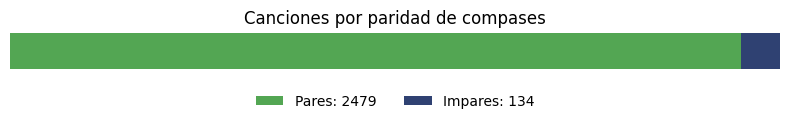

In [13]:
import matplotlib.pyplot as plt

# --- Cálculos ---
pares = int((raw_df['bars'] % 2 == 0).sum())
impares = int((raw_df['bars'] % 2 == 1).sum())

vals = [pares, impares]
labels = ["Pares", "Impares"]
colors = ["#53A653", "#2F4172"]  # verde y azul oscuro

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 1.6))

# Barras apiladas
ax.barh(0, vals[0], color=colors[0])
ax.barh(0, vals[1], left=vals[0], color=colors[1])

# Limpieza estética
ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim(0, sum(vals))
ax.set_title("Canciones por paridad de compases")

# Leyenda con conteos
ax.legend([f"Pares: {pares}", f"Impares: {impares}"], 
          loc="upper center", bbox_to_anchor=(0.5, -0.3),
          ncol=2, frameon=False)

plt.tight_layout()
plt.show()


## Chordprog

In [14]:
from collections import Counter

def acordes_unicos(df, columna="progresion_funcional", contar=False):
    """
    Devuelve:
      - un set con acordes únicos encontrados en la columna especificada
      - opcionalmente (si contar=True), un Counter con las frecuencias
    Ignora el símbolo de barra de compás '|'.
    """
    progresiones = df[columna].dropna().tolist()
    tokens = []
    for prog in progresiones:
        tokens.extend([t for t in prog.split() if t != '|'])

    if contar:
        return set(tokens), Counter(tokens)
    else:
        return set(tokens)


número de acordes únicos: 1532


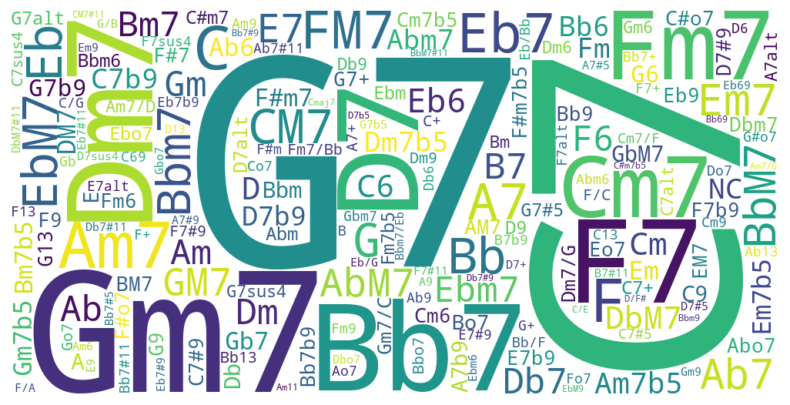

In [19]:
# %pip install wordcloud
from wordcloud import WordCloud
acordes, frecuencias = acordes_unicos(raw_df, "chordprog", contar=True)
print(f'número de acordes únicos: {len(acordes)}')
# Generar la nube de palabras
wc = WordCloud(
    width=1000, height=500, background_color="white",
    collocations=False, regexp=r"[^\s]+"
).generate_from_frequencies(frecuencias)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [27]:
from collections import Counter

def extraer_ngrams(progresiones, n=3):
    """
    Extrae todos los n-gramas de acordes de una lista de progresiones.
    Devuelve un contador con la frecuencia de cada n-grama.
    """
    ngram_counts = Counter()

    for prog in progresiones:
        if not isinstance(prog, str):
            continue
        tokens = prog.split()
        # Excluye las barras de compás para que no cuenten como acordes
        tokens = [t for t in tokens if t != "|"]
        if len(tokens) >= n:
            for i in range(len(tokens) - n + 1):
                ngram = tuple(tokens[i:i+n])
                ngram_counts[ngram] += 1

    return ngram_counts
progresiones = raw_df['chordprog'].dropna().tolist()
ngram_counts = extraer_ngrams(progresiones, n=3)
# Mostrar los 10 n-gramas más comunes
ngram_counts.most_common(10)

[(('Gm7', 'C7', 'FM7'), 596),
 (('Fm7', 'Bb7', 'EbM7'), 554),
 (('Dm7', 'G7', 'CM7'), 435),
 (('Cm7', 'F7', 'BbM7'), 369),
 (('C', 'C', 'C'), 346),
 (('G7', 'G7', 'G7'), 345),
 (('Bbm7', 'Eb7', 'AbM7'), 336),
 (('Gm7', 'C7', 'F'), 326),
 (('Am7', 'D7', 'GM7'), 286),
 (('Dm7', 'G7', 'C'), 285)]

Mostrar los n-gramas más comunes en las progresiones de acordes, revela que la progresión más común II-V-I aparece en múltiples tonalidades diferentes. Para nuestro objetivo será imprescindible una capa de abstraccion que nos permita identificar estas progresiones independientemente de la tonalidad. Esto nos lleva a la necesidad de trabajar con notación funcional. 

## Parseo de acordes: C7 > (0, '7')
Este proceso nos permitirá desgranar los acordes en dos partes de información sustanciales: la raíz (o nota fundamental) y el tipo de acorde (o extensión) -menor, mayor...etc.-.

In [20]:
import re
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 4.5)


In [21]:
PITCHES_SHARP = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
PITCHES_FLAT  = ["C","Db","D","Eb","E","F","Gb","G","Ab","A","Bb","B"]
PITCH_TO_PC = {p:i for i,p in enumerate(PITCHES_SHARP)}
PITCH_TO_PC.update({p:i for i,p in enumerate(PITCHES_FLAT)})

ENHARMONIC_ROOT = {"Cb": "B", "B#": "C", "Fb": "E", "E#": "F"}

QUAL_CANON = {
    "maj7":"maj7","M7":"maj7","Δ":"maj7","maj":"maj","M":"maj",
    "min":"m","m":"m","-":"m","m7":"m7","mMaj7":"mMaj7","mM7":"mMaj7",
    "dim":"dim","o":"dim","o7": "dim7", "dim7":"dim7","aug":"aug","+":"aug",
    "7":"7","9":"7","11":"7","13":"7",
    "ø":"m7b5","m7b5":"m7b5","halfdim":"m7b5",
    "sus2":"sus","sus4":"sus","sus":"sus",
    "6":"maj","69":"maj",
    "add9":"maj"
}

REDUCE_TO_CLASS = {
    "maj7":"maj7","maj":"maj7",
    "m":"m7","m7":"m7","mMaj7":"m7",
    "7":"7",
    "m7b5":"m7b5",
    "dim":"dim7","dim7":"dim7",
    "aug":"7","sus":"7",
}

CHORD_RE = re.compile(r"""^\s*
    (?P<root>[A-Ga-g])(?P<acc>[#b♭♯]?)
    \s*
    (?P<qual>maj7|maj|M7|M|Δ|dim7|dim|m7b5|ø|o7|o|mMaj7|mM7|m7|m|min|aug|\+|7|9|11|13|6|69|sus2|sus4|sus|add9)?
    (?P<rest>.*?)
    \s*$""", re.VERBOSE)


def split_sequence(raw: str) -> list[str]:
    toks = re.split(r"[,\s;\|]+", str(raw).strip())
    return [t for t in toks if t]

def parse_chord_extended(token: str):
    """
    Devuelve un dict con:
      - ok: bool
      - token: texto original
      - pc: pitch class (0-11) si parsea
      - qual_raw: cualidad capturada por el regex (puede ser "")
      - qual_canon: cualidad canonicalizada (según QUAL_CANON)
      - class_reduced: clase reducida (según REDUCE_TO_CLASS)
      - reason: si falla, motivo aproximado
    """
    t = (token or "").strip()
    if not t:
        return {"ok": False, "reason": "empty"}

    m = CHORD_RE.match(t)
    if not m:
        return {"ok": False, "reason": "regex_no_match"}

    root = m.group("root").upper()
    acc = m.group("acc").replace("♭","b").replace("♯","#")
    root_name = root + (acc if acc in ["#","b"] else "")
    if root_name in ENHARMONIC_ROOT:
        root_name = ENHARMONIC_ROOT[root_name]
    if root_name not in PITCH_TO_PC:
        return {"ok": False, "reason": "root_not_in_pcmap"}

    pc = PITCH_TO_PC[root_name]
    qual_raw = m.group("qual") or ""
    qual = QUAL_CANON.get(qual_raw, qual_raw)

    # Heurística si no hay cualidad explícita
    if qual == "":
        rest = (m.group("rest") or "").lower()
        if "m" in rest and "maj" not in rest:
            qual = "m"
        else:
            qual = "maj"

    qual_canon = QUAL_CANON.get(qual, qual)
    class_reduced = REDUCE_TO_CLASS.get(qual_canon, "maj7")

    return {
        "ok": True,
        "pc": pc,
        "qual_raw": qual_raw if qual_raw != "" else "(vacía/heurística)",
        "qual_canon": qual_canon,
        "class_reduced": class_reduced
    }


In [23]:
def explode_chordprog(df: pd.DataFrame, col: str = "chordprog") -> pd.DataFrame:
    rows = []
    for i, raw in df[col].dropna().items():
        for tok in split_sequence(raw):
            rows.append({"row_id": i, "token": tok})
    return pd.DataFrame(rows)

tokdf = explode_chordprog(raw_df, "chordprog")

parsed_rows = []
for tok in tokdf["token"]:
    info = parse_chord_extended(tok)
    parsed_rows.append(info)

tokdf_parsed = pd.concat([tokdf.reset_index(drop=True), pd.DataFrame(parsed_rows)], axis=1)
tokdf_parsed.head(5)


,row_id,token,ok,pc,qual_raw,qual_canon,class_reduced,reason
0,0,Fm7,True,5.0,m7,m7,m7,NaN
1,0,Dm7b5,True,2.0,m7b5,m7b5,m7b5,NaN
2,0,G7b9,True,7.0,7,7,7,NaN
3,0,C7b9,True,0.0,7,7,7,NaN
4,0,Fm7,True,5.0,m7,m7,m7,NaN


In [24]:
total = len(tokdf_parsed)
ok = tokdf_parsed["ok"].sum()
print(f"Tokens totales: {total}")
print(f"Parseados OK : {ok}  ({ok/total:.1%})")
print(f"Fallidos     : {total-ok}  ({(total-ok)/total:.1%})")

err = tokdf_parsed.loc[~tokdf_parsed["ok"], "reason"].value_counts().head(10)
print("\nTop motivos de fallo:")
print(err)

tokdf_parsed.loc[~tokdf_parsed["ok"], ["token","reason"]]['token'].value_counts()

Tokens totales: 134339
Parseados OK : 133756  (99.6%)
Fallidos     : 583  (0.4%)

Top motivos de fallo:
reason
regex_no_match    583
Name: count, dtype: int64


token
NC    583
Name: count, dtype: int64

Solo nos faltaría gestionar los NC (No Chord)

In [25]:
from IPython.display import display  

okdf = tokdf_parsed[tokdf_parsed["ok"]].copy()

def top_counts(series: pd.Series, topn=30, title=""):
    vc = series.value_counts(dropna=False)
    dfc = pd.DataFrame({
        "count": vc,
        "pct(%)": (vc / vc.sum() * 100).round(2)
    })
    if title:
        print(title)
    display(dfc.head(topn))
    return vc

print("=== CUALIDADES RAW (regex) ===")
vc_raw = top_counts(okdf["qual_raw"], 30, "qual_raw")

print("=== CUALIDADES CANÓNICAS ===")
vc_canon = top_counts(okdf["qual_canon"], 30, "qual_canon")

print("=== CLASES REDUCIDAS ===")
vc_reduced = top_counts(okdf["class_reduced"], 30, "class_reduced")


=== CUALIDADES RAW (regex) ===
qual_raw


,count,pct(%)
qual_raw,,
7,45184,33.78
m7,28933,21.63
(vacía/heurística),17416,13.02
M7,14439,10.80
m,9485,7.09
6,5130,3.84
m7b5,3701,2.77
9,2823,2.11
o7,2528,1.89


=== CUALIDADES CANÓNICAS ===
qual_canon


,count,pct(%)
qual_canon,,
7,49550,37.05
m7,28933,21.63
maj,23229,17.37
maj7,14683,10.98
m,9485,7.09
m7b5,3701,2.77
dim7,2539,1.90
aug,546,0.41
dim,484,0.36


=== CLASES REDUCIDAS ===
class_reduced


,count,pct(%)
class_reduced,,
7,50304,37.61
m7,38816,29.02
maj7,37912,28.34
m7b5,3701,2.77
dim7,3023,2.26


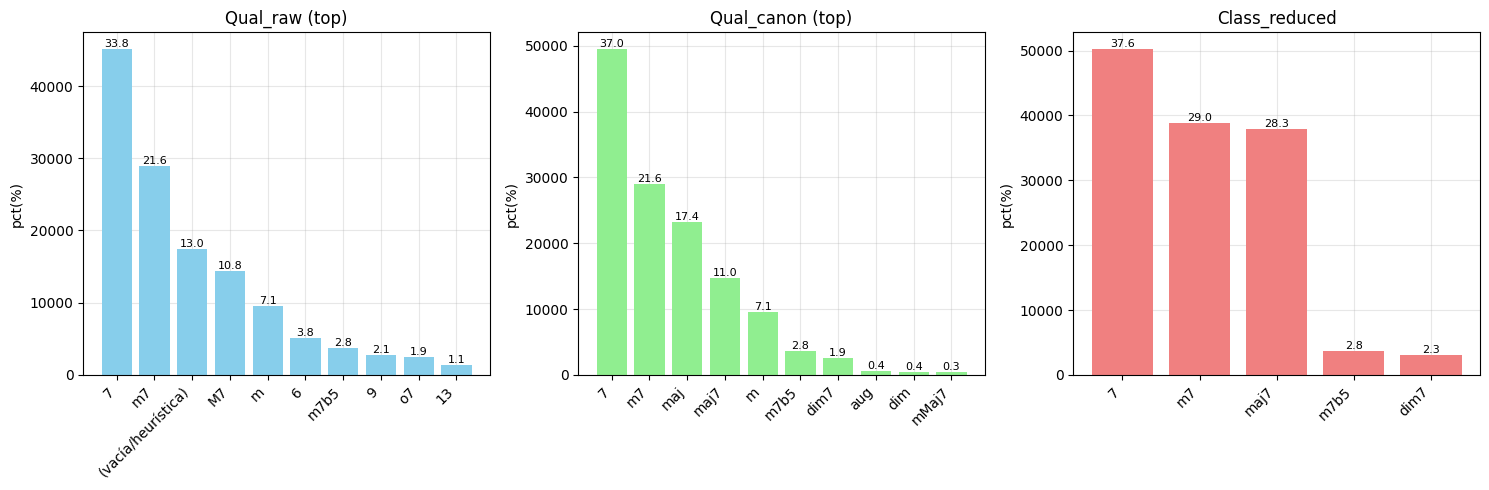

In [26]:
# Crear figura con 3 subplots horizontales
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Configurar datos para cada gráfico
plots_data = [
    (vc_raw, "Qual_raw (top)", "skyblue"),
    (vc_canon, "Qual_canon (top)", "lightgreen"), 
    (vc_reduced, "Class_reduced", "lightcoral")
]

# Crear cada subplot
for i, (data, title, color) in enumerate(plots_data):
    # Tomar los top 10 valores
    top_data = data.head(10)
    
    # Crear barplot
    axes[i].bar(range(len(top_data)), top_data.values, color=color)
    
    # Configurar etiquetas del eje x
    axes[i].set_xticks(range(len(top_data)))
    axes[i].set_xticklabels(top_data.index, rotation=45, ha='right')
    
    # Configurar título y etiquetas
    axes[i].set_title(title)
    axes[i].set_ylabel('pct(%)')
    
    # Añadir valores en las barras
    for j, v in enumerate(top_data.values):
        pct = (v / data.sum() * 100)
        axes[i].text(j, v + 0.5, f'{pct:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Configurar grid
    axes[i].grid(True, alpha=0.3)
    axes[i].set_axisbelow(True)

# Ajustar layout
plt.tight_layout()
plt.show()